In [339]:
import librosa
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering



In [340]:
# loading dictionaru with translated letters to morse code
with open('./../../data_scripts/morse_code.json', "r", encoding='utf-8') as file:
    morse_code = json.load(file)

In [306]:
from_morse = {}
for key, value in morse_code.items():
    from_morse[value] = key

In [307]:
#  translating sentances into morse code
def translator_from_text(text):
    return " ".join("_".join([",".join([i for i in morse_code.get(i)]) for i in word]) for word in text.upper().split(" "))

In [308]:
#  translating sentances into morse code
def translator_from_morse(text):
    return " ".join(["".join([from_morse.get("".join(sign.split(","))) for sign in word.split("_")]) for word in text.split(" ")])

In [309]:
# loading dictionaru with translated letters to morse code
with open('./../../data/labels/labels_test.json', "r", encoding='utf-8') as file:
    labels = json.load(file)

In [592]:
existing_file_path ="./../../data/audio/morse_text_audio_files_train/steel/12_steel.wav"#"./../../data/audio/morse_text_audio_files_test/guitar1/136_guitar1.wav"
samples, sampling_rate = librosa.load(existing_file_path)#, sr=5500, mono=True, offset=0.0
                        # , duration=None)

In [800]:
existing_file_path = "/Users/zuzannaglinka/taros-deep-learning/data/audio/unused/morse_text_audio_files/glass/0_glass.wav"#"./../../data/audio/morse_text_audio_files_test/guitar1/136_guitar1.wav"
samples, sampling_rate = librosa.load(existing_file_path)#, sr=5500, mono=True, offset=0.0
                        # , duration=None)

In [427]:
def dict_class_to_morse(cluster_centers):
    dict = {}
    if len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 1:
        dict[0] = ','
        dict[1] = '.'
    elif len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 2:
        if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]>abs(cluster_centers[1]):
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
        elif abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 1:
        if abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = ','
            dict[1] = '.'
            dict[2] = '-'
        elif abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = '.'
            dict[2] = '-'
        elif abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1]:
            dict[0] = ' '
            dict[1] = '.'
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 2:
        if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1] and cluster_centers[cluster_centers>0][1] > abs(cluster_centers[1]) > cluster_centers[cluster_centers>0][0]:
            dict[0] = ' '
            dict[1] = '_'
            dict[2] = '.'
            dict[3] = '-'
        elif  cluster_centers[cluster_centers>0][0] < abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][1] and abs(cluster_centers[1]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'
        elif  abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][1] and abs(cluster_centers[1]) < cluster_centers[cluster_centers>0][0]:
            dict[0] = ' '
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'

    elif len(cluster_centers) == 5:
        dict[0] = ' '
        dict[1] = '_'
        dict[2] = ','
        dict[3] = '.'
        dict[4] = '-'
    return dict

In [1170]:
def sound_translator(path):
    samples, sampling_rate = librosa.load(path, sr=5500, mono=True, offset=0.0
                        , duration=None)
    max_abs_scaler = preprocessing.MaxAbsScaler()
    new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
    # new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
    bin_samples = [1 if abs(new_val)>0.05 else 0 for new_val in new_samples]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    new_bin_samples =  [1 for i in range(30)] + \
    [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-30:i]) > 0 and np.sum(bin_samples[i:i+30]) > 0)) else 0) \
     for i in list(range(30, len(bin_samples)-30))] + \
          [1 for i in range(30)]
    
    new_list = []
    k = 0
    for i in range(len(new_bin_samples)-1):
        if new_bin_samples[i] != new_bin_samples[i+1]:
            if new_bin_samples[i] == 1:
                new_list.append(i-k+1)
            else:
                new_list.append(-(i+1-k))
            k = i 
    new_list.append(len(new_bin_samples)-k)
    new_list = [i for i in new_list if abs(i)>max(new_list)/10]

    scaler = StandardScaler()
    scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
    silhouette_coefficients = []
    for k in range(2, 6):
        if(len(scaled)>k):
            clustering = SpectralClustering(n_clusters=k).fit(scaled)
            score = silhouette_score(scaled, clustering.labels_)
            silhouette_coefficients.append(score)

    n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
    clustering = SpectralClustering(n_clusters=n_clust)
    clustering.fit(scaled)
    
    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = clustering.labels_

    cB0 =df['class']
    ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
    cntrs = np.zeros_like(cB0)-1
    for i in np.arange(n_clust):
        cntrs[cB0==ord_idx[i]]=i

    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = cntrs
    # df['class'] += len(df.loc[df['length']<0, 'class'].unique())
    # if(len(df['class'].unique()) == 3):
        # df.loc[df['class']==4,'class'] = 0
    # df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())+(1 if (len(df['class'].unique()) == 3) else 0)]  if row['length'] < 0 and row['class']!= 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')
    # print(df['class'].unique())
    # print(df.head(20))
    # df = pd.DataFrame(columns = ['length', 'class'])
    # df['length'] = new_list
    # df['class'] = cntrs + len(df.loc[df['length']<0, 'class'].unique())
    # df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())]  if row['length'] < 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')
    # print(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
    dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
    try:
        return translator_from_morse("".join([dict.get(i) for i in df['class']])) 
    
    # except TypeError as error:
    #     return "".join([i for i in df['class']])
    except:
        return "Cant translate sound"

In [1160]:
sound_translator("/Users/zuzannaglinka/Downloads/koza_jest_fajna.wav")

[4 2 3 1 0]
{0: ' ', 1: '_', 2: ',', 3: '.', 4: '-'}


'KOZA JEST FAJNA'

In [1161]:
sound_translator("/Users/zuzannaglinka/taros-deep-learning/data/audio/unused/morse_text_audio_files/steel/3_steel.wav")

[4 2 3 1 0]
{0: ' ', 1: '_', 2: ',', 3: '.', 4: '-'}


'BRAD CAME TO DINNER WITH US.'

In [1162]:
sound_translator("./../../data/audio/morse_text_audio_files_train/clap/12_clap.wav")

[1 0]
{0: ',', 1: '.'}


'I'

In [1155]:
sound_translator("./../../data/audio/morse_text_audio_files_val/beep/12_beep.wav")

[4 1 3 2 0]
{0: ' ', 1: '_', 2: ',', 3: '.', 4: '-'}
-_.,.,-_-,.,-,._-,.,- -_.,.,.,._. .,.,._.,.,.,._._._- .,.,-_-,._-,.,._._.,-,. -_.,.,.,._. ._-,.,._-,-,._. -,-,-_.,.,-,. -_.,.,.,._. -,-_.,-_-_.,-,-,.,-,.,-


'TUCK THE SHEET UNDER THE EDGE OF THE MAT.'

In [1040]:
samples, sampling_rate = librosa.load("./../../data/audio/morse_text_audio_files_train/glass/11_glass.wav", sr=5500, mono=True, offset=0.0
                    , duration=None)

In [867]:
samples, sampling_rate = librosa.load("./../../data/audio/morse_text_audio_files_train/glass/145_glass.wav", sr=5500, mono=True, offset=0.0
                    , duration=None)

In [1083]:
samples, sampling_rate = librosa.load("./../../data/audio/morse_text_audio_files_train/clap/145_clap.wav", sr=5500, mono=True, offset=0.0
                    , duration=None)

In [1169]:
sound_translator("/Users/zuzannaglinka/Downloads/morse3dow.wav")

[1 2 0 3]
{}


'Cant translate sound'

In [1084]:
max_abs_scaler = preprocessing.MaxAbsScaler()
new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)

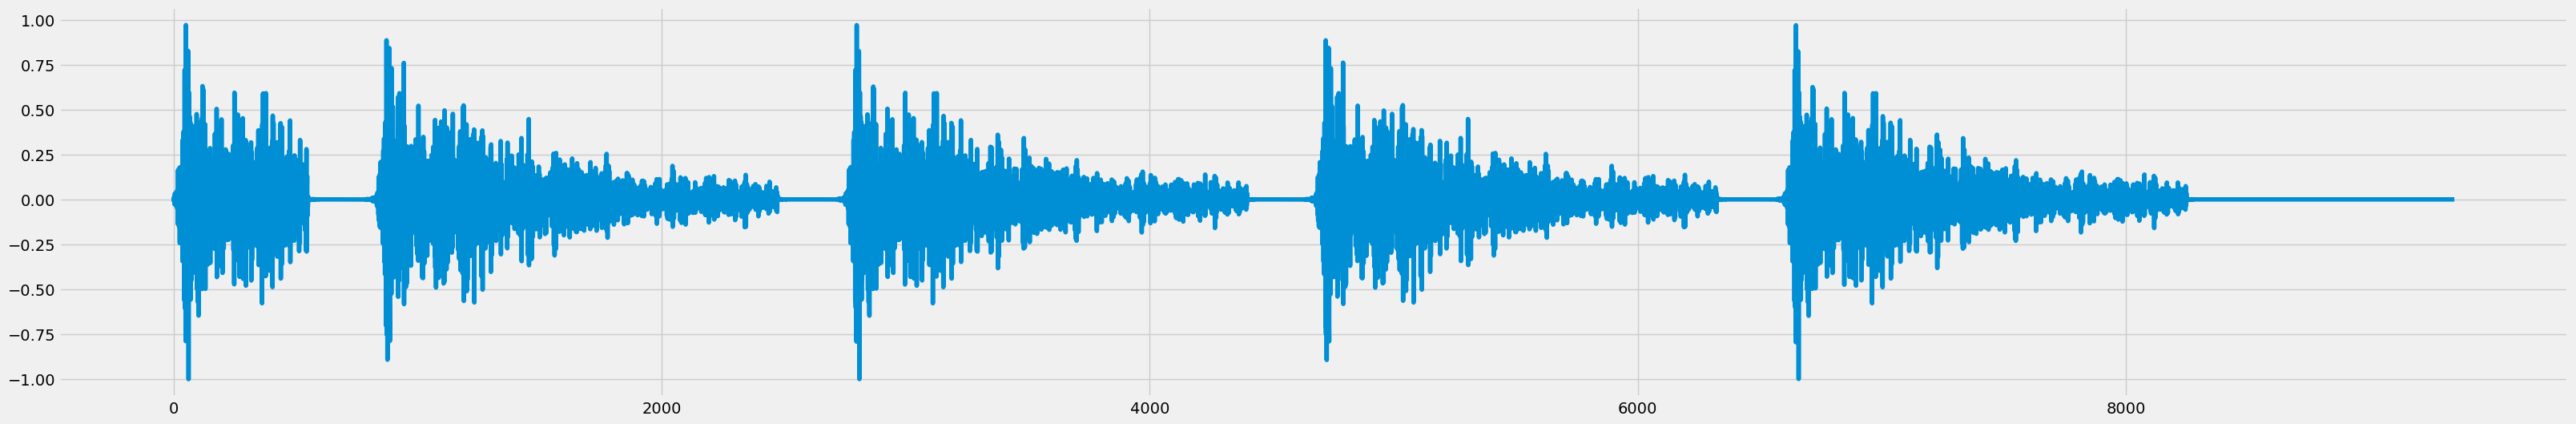

In [1085]:
fig = plt.figure(figsize=(36, 6))
plt.plot(new_samples)
# plt.scatter( [i for i, e in enumerate(labels) if e == 1], [0 for i in labels if i ==1], c = 'red', zorder = 2)


In [1088]:
bin_samples = [1 if abs(new_val)>0.03 else 0 for new_val in new_samples]
# usuwanie ciszy na koncu i na poczatku pliku 
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]


In [1089]:
new_bin_samples =  [1 for i in range(30)]+ [(1 if (bin_samples[i] ==1 or (bin_samples[i] == 0 and np.sum(bin_samples[i-30:i]) != 0 and np.sum(bin_samples[i+1:i+30]) != 0)) else 0) for i in list(range(30, len(bin_samples)-30))] + [1 for i in range(30)]


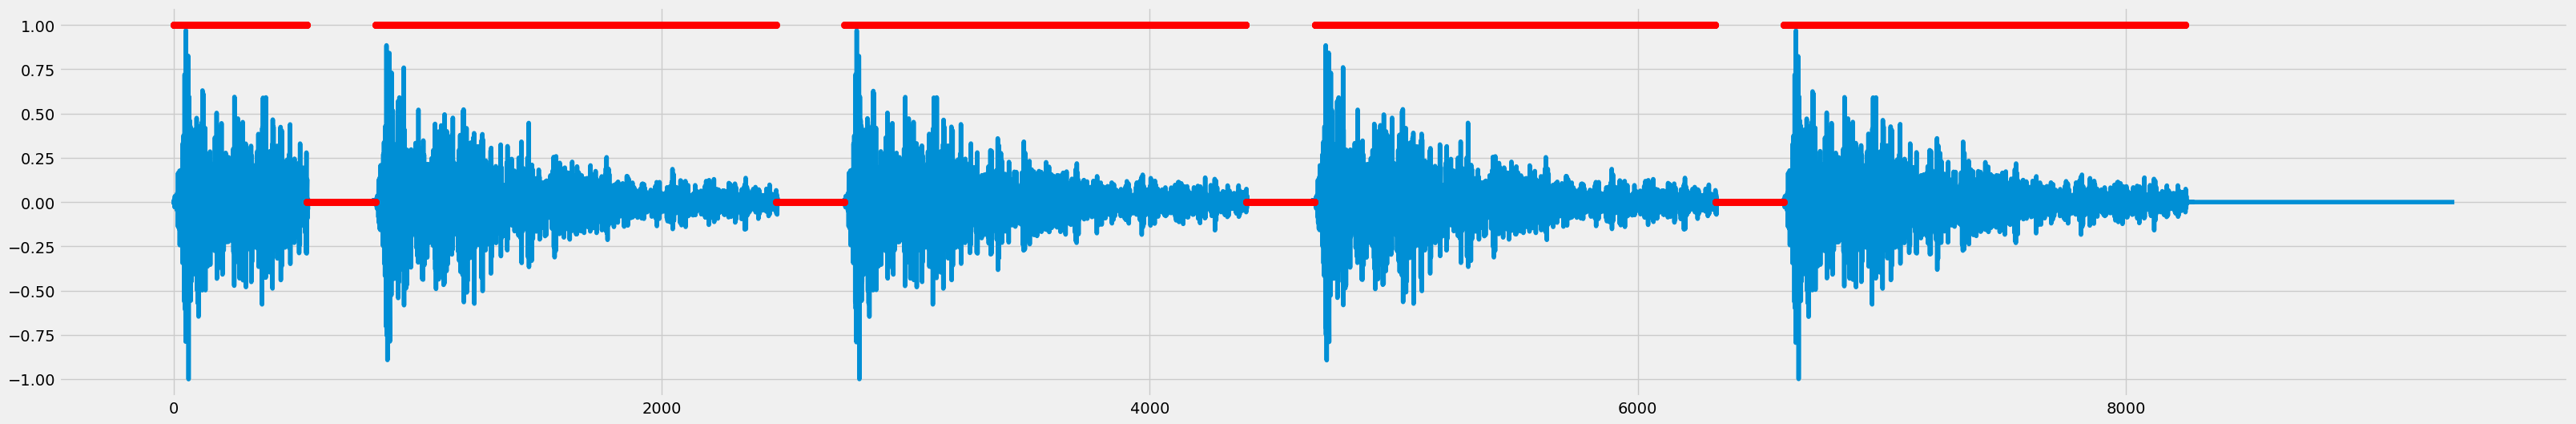

In [1090]:
fig = plt.figure(figsize=(36, 6))
# plt.scatter([i for i, e in enumerate(new_bin_samples) if e == 1], [0 for i in new_bin_samples if i ==1],color = 'red', zorder =2)
plt.scatter([i for i, e in enumerate(new_bin_samples)],  new_bin_samples,color = 'red', zorder =2)

plt.plot(range(len(new_samples)), new_samples, zorder = 1)
plt.show()

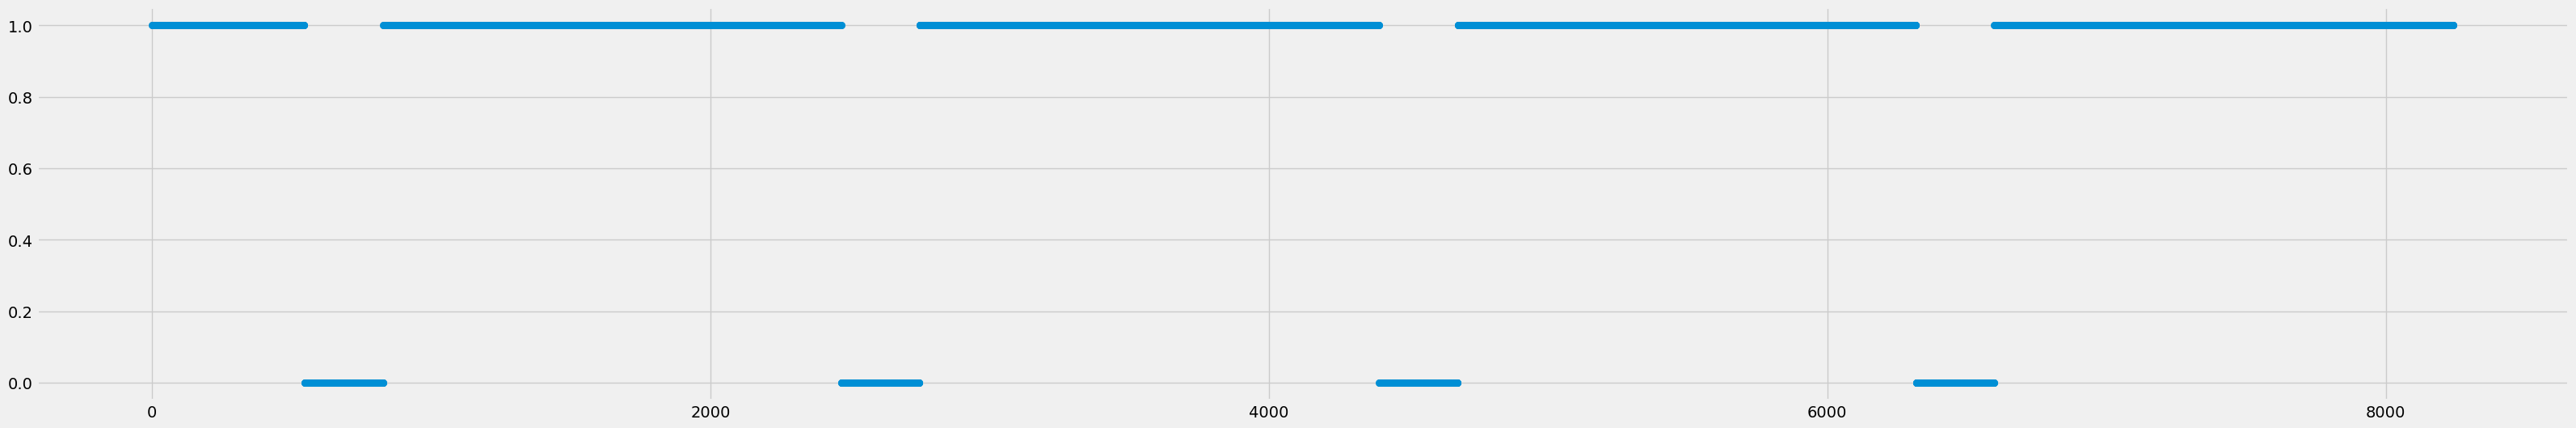

In [1091]:
fig = plt.figure(figsize=(36, 6))
plt.scatter(range(len(new_bin_samples)), new_bin_samples)

In [1092]:
new_list = []
k = 0
for i in range(len(new_bin_samples)-1):
    if new_bin_samples[i] != new_bin_samples[i+1]:
        if new_bin_samples[i] == 1:
            new_list.append(i-k+1)
        else:
            new_list.append(-(i+1-k))
        k = i 
new_list.append(len(new_bin_samples)-k)

(array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]),
 array([-276.  , -237.46, -198.92, -160.38, -121.84,  -83.3 ,  -44.76,
          -6.22,   32.32,   70.86,  109.4 ,  147.94,  186.48,  225.02,
         263.56,  302.1 ,  340.64,  379.18,  417.72,  456.26,  494.8 ,
         533.34,  571.88,  610.42,  648.96,  687.5 ,  726.04,  764.58,
         803.12,  841.66,  880.2 ,  918.74,  957.28,  995.82, 1034.36,
        1072.9 , 1111.44, 1149.98, 1188.52, 1227.06, 1265.6 , 1304.14,
        1342.68, 1381.22, 1419.76, 1458.3 , 1496.84, 1535.38, 1573.92,
        1612.46, 1651.  ]),
 <BarContainer object of 50 artists>)

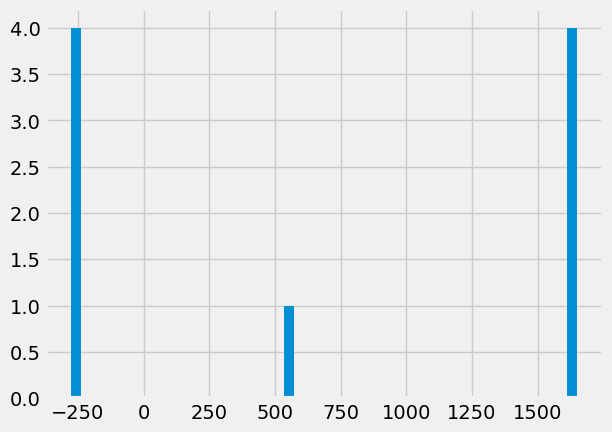

In [740]:
plt.hist([i for i in new_list if abs(i)>50], 50)

In [1053]:
new_list = [i for i in new_list if abs(i)>50]

In [1052]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [690]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering


In [1173]:
scaler = StandardScaler()
scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
silhouette_coefficients = []
for k in range(2, 6):
    if(len(scaled)>k):
        print(k)
        # kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        clustering = SpectralClustering(n_clusters=k).fit(scaled)
        # estimator = make_pipeline(StandardScaler(), kmeans).fit(np.array(new_list).reshape(1,-1).T)
        # kmeans.fit(scaled)
        print(clustering.labels_)

        score = silhouette_score(scaled, clustering.labels_)
        print(score)
        silhouette_coefficients.append(score)



2
[1 1 0 1 0 1 0 1 0]
0.8674224291628501
3
[2 1 0 1 0 1 0 1 0]
0.8868245489209234
4
[1 2 0 2 0 2 0 3 0]
0.4430957970573544
5
[3 0 1 4 1 0 1 2 1]
0.6653180192795767


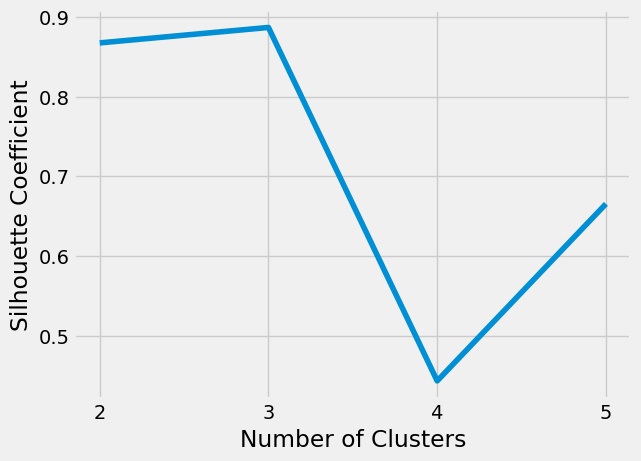

In [1175]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [1176]:
n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
clustering = SpectralClustering(n_clusters=n_clust)
clustering.fit(scaled)

SpectralClustering(n_clusters=3)

In [1177]:
# Final locations of the centroid
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = clustering.labels_
df.head(15)


,length,class
0,546,2
1,-283,0
2,1642,1
3,-281,0
4,1647,1
5,-283,0
6,1642,1
7,-281,0
8,1647,1


In [1178]:
cB0 =df['class']
ord_idx=np.argsort(df.abs().groupby(['class']).mean()['length'])
cntrs = np.zeros_like(cB0)-1
for i in np.arange(n_clust):
    cntrs[cB0==ord_idx[i]]=i

print(cntrs)

[1 0 2 0 2 0 2 0 2]


In [1112]:
df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
# df['class'] += len(df.loc[df['length']<0, 'class'].unique())
# print(df['class'].unique())
# if(len(df['class'].unique()) == 3):
#     df.loc[df['class']==4,'class'] = 0
# df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())+(1 if len(df['class'].unique()) == 3 else 0)]  if row['length'] < 0 and row['class']!= 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')
# else:
#         df = df.apply(lambda row:[row['length'], row['class']-len(df.loc[df['length']<0, 'class'].unique())]  if row['length'] < 0 and row['class']!= 0 else [row['length'], row['class']], axis=1, result_type = 'broadcast')


[1 2]


In [1129]:
class_to_sign = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)

In [1130]:
class_to_sign

{0: ',', 1: '.', 2: '-'}

In [1131]:
[class_to_sign.get(i) for i in df['class']]

['.', ',', '-', ',', '-', ',', '-', ',', '-']

In [1132]:
text = "".join([class_to_sign.get(i) for i in df['class']])
text

'.,-,-,-,-'

In [1133]:
translator_from_morse("".join([class_to_sign.get(i) for i in df['class']]))

'1'